# Invalid Record Analysis
In this notebook, we investigate and analyze the records which were not processed by the server. We aim to provide an empirical reasoning behind why the model may have potentially rejected the provided data.

In [1]:
import numpy as np
import seaborn as sns
from scipy import stats
import modin.pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Process STDOUT and STDERR is being redirected to /tmp/raylogs/.
Waiting for redis server at 127.0.0.1:31430 to respond...
Waiting for redis server at 127.0.0.1:57022 to respond...
Starting the Plasma object store with 4.00 GB memory.


## Guiding Questions
In particular, here are some things we will analyze:
* Distribution of sequence length of all rejected sequence of peptides.
* What are the common set of sequences which are not processed across all servers and across each type of permuation.
* Correlation between method of permuation and the frequency of rejection by the server.
* Why DBAASP has a highest rate of missing data while it also has the highest AUC/ROC score.
* New metric to evaluate the model taking into the account the number of sample it rejected to evaluate.

In [2]:
# Application Hyperparameters
DATA_ROOT = '../data/out/data3.fasta.txt/'
# SERVERS = ['ADAM_HMM', 'ADAM_SVM', 'AMPA', 'CAMPR3-ANN', 'CAMPR3-DA', 'CAMPR3-RF', 'CAMPR3-SVM']
SERVERS = ['ADAM_HMM', 'ADAM_SVM', 'AMPA', 'CMPR3_ANN', 'CMPR3_DA', 'CMPR3_RF', 'CMPR3_SVM', 'DBAASP']
DATASET = ['A', 'D'] # A for AMP3 and D for DAMPD
REVERSE = ['', 'R', 'R1', 'R2', 'R3']

## Load Dataset

In [3]:
data = {}
for s in SERVERS:
    raw = pd.read_csv(DATA_ROOT + s + '.csv')
    data[s] = {}
    for d in DATASET:
        data[s][d] = {}
        for r in REVERSE:
            # Append True Values
            data[s][d][r] = pd.DataFrame(raw[raw.PepID.str.contains(d)][raw.PepID.str.contains('R') == False][raw.AMPLabel == 1])
            
            # Filter Out by
            if r == '':
                data[s][d][r] = data[s][d][r].append(raw[raw.PepID.str.contains(d)][raw.AMPLabel == 0][raw.PepID.str.contains('R') == False])
            elif r == 'R':
                data[s][d][r] = data[s][d][r].append(raw[raw.PepID.str.contains(d)][raw.PepID.str.contains('R') == True][raw.PepID.str.contains('R1') == False][raw.PepID.str.contains('R2') == False][raw.PepID.str.contains('R3') == False])
            else:
                data[s][d][r] = data[s][d][r].append(raw[raw.PepID.str.contains(d)][raw.PepID.str.contains(r)])
            
            # print(s + ' ['+d+r+']' + ' : ' + str(data[s][d][r].shape[0]) + ' RECORDS')
        # print('-'*30)

In [4]:
# Filter -999 Values
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            pre_filter = data[s][d][r].shape[0]
            data[s][d][r] = data[s][d][r][data[s][d][r].PredLabel == -999]
            print(s + ' ['+d+r+']' + ' (POST-FILTERED): ' + str(data[s][d][r].shape[0]) + ' RECORDS ' + '('+ str(pre_filter - data[s][d][r].shape[0]) +' FILTERED)')
        print('-'*75)

ADAM_HMM [A] (POST-FILTERED): 2 RECORDS (10276 FILTERED)
ADAM_HMM [AR] (POST-FILTERED): 0 RECORDS (3426 FILTERED)
ADAM_HMM [AR1] (POST-FILTERED): 0 RECORDS (3426 FILTERED)
ADAM_HMM [AR2] (POST-FILTERED): 0 RECORDS (3426 FILTERED)
ADAM_HMM [AR3] (POST-FILTERED): 0 RECORDS (3426 FILTERED)
---------------------------------------------------------------------------
ADAM_HMM [D] (POST-FILTERED): 25 RECORDS (3256 FILTERED)
ADAM_HMM [DR] (POST-FILTERED): 16 RECORDS (1078 FILTERED)
ADAM_HMM [DR1] (POST-FILTERED): 16 RECORDS (1078 FILTERED)
ADAM_HMM [DR2] (POST-FILTERED): 16 RECORDS (1078 FILTERED)
ADAM_HMM [DR3] (POST-FILTERED): 16 RECORDS (1078 FILTERED)
---------------------------------------------------------------------------
ADAM_SVM [A] (POST-FILTERED): 4 RECORDS (10274 FILTERED)
ADAM_SVM [AR] (POST-FILTERED): 0 RECORDS (3426 FILTERED)
ADAM_SVM [AR1] (POST-FILTERED): 0 RECORDS (3426 FILTERED)
ADAM_SVM [AR2] (POST-FILTERED): 0 RECORDS (3426 FILTERED)
ADAM_SVM [AR3] (POST-FILTERED): 0 RECO

## Sequence Length Intersection
This section analyzes the overall distribution of the sequence length of rejected value. We hypothesize that the longer the sequence, the less likely the model will process that data.

In [5]:
seq_lens = []
for d in DATASET:
    for s in SERVERS:
        for r in REVERSE:
            if data[s][d][r].shape[0] > 0:
                seq_lens += data[s][d][r]['PepSeq'].apply(len).tolist()

print(stats.describe(seq_lens))

DescribeResult(nobs=2481, minmax=(11, 712), mean=137.03264812575574, variance=14892.554982057183, skewness=2.1844421950277315, kurtosis=6.299158247304865)


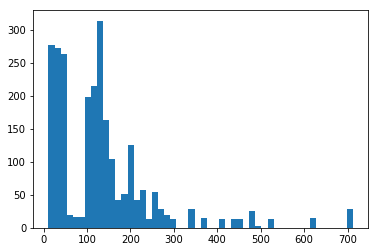

In [6]:
plt.hist(seq_lens, bins=50)
plt.show()

## Inner-Model + Data Intersection Analysis
This attempts to analyze the intersection of elements which are not valid across different permutations with respect to the different permutation methods.

In [7]:
for d in DATASET:
    for s in SERVERS:
        print('[' + d + ']' + ' ' + s)
        sets = []
        for r in REVERSE:
            if data[s][d][r].shape[0] > 0:
                sets.append(data[s][d][r]['PepID'].tolist())
        result = set(sets[0]).intersection(*sets[:1])
        print(sorted(list(result)))

[A] ADAM_HMM
['A06714', 'A09393']
[A] ADAM_SVM
['A06708', 'A06720', 'A09383', 'A09392']
[A] AMPA
['A00070', 'A00073', 'A00111', 'A00129', 'A00188', 'A00193', 'A00204', 'A00235', 'A00309', 'A00368', 'A00912', 'A01386', 'A01447', 'A01703', 'A03437', 'A03635', 'A03976', 'A04459', 'A05453', 'A06094', 'A06133', 'A06134', 'A06138', 'A06886', 'A06887', 'A08880', 'A09899', 'A10751', 'A10753', 'A10754', 'A11790']
[A] CMPR3_ANN
['A06722', 'A09393']
[A] CMPR3_DA
['A06722', 'A09393']
[A] CMPR3_RF
['A06722', 'A09393']
[A] CMPR3_SVM
['A06722', 'A09393']
[A] DBAASP
['A01209', 'A01210', 'A01242', 'A01244', 'A01245', 'A01246', 'A01247', 'A01248', 'A01253', 'A01266', 'A01267', 'A01269', 'A01271', 'A01273', 'A01305', 'A01321', 'A01334', 'A01335', 'A01337', 'A01346', 'A01381', 'A01382', 'A01383', 'A01694', 'A01695', 'A01696', 'A01697', 'A01698', 'A01707', 'A01712', 'A01713', 'A04522', 'A04523', 'A04555', 'A04557', 'A04558', 'A04559', 'A04560', 'A04561', 'A04566', 'A04579', 'A04580', 'A04582', 'A04584', 'A